# Action Recognition with an Inflated 3D CNN
This uses the [i3d-kinetics-400](https://www.kaggle.com/models/deepmind/i3d-kinetics/tensorFlow1/400/1?tfhub-redirect=true) module, which is a I3D model pre-trained on the kinetics-400 dateset. The tutorial uses it to make predictions on the UCF101 Dataset, but it also works on our dataset.

- Tutorial: https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub
- UCF101 Dataset: https://www.kaggle.com/datasets/matthewjansen/ucf101-action-recognition

In [169]:
# TensorFlow and TF-Hub modules.
from absl import logging

import tensorflow as tf
import tensorflow_hub as hub
# from tensorflow_docs.vis import embed

logging.set_verbosity(logging.ERROR)

# Some modules to help with reading the UCF101 dataset.
import random
import re
import os
import tempfile
import ssl
import cv2
import numpy as np

# Some modules to display an animation using imageio.
import imageio
from IPython import display

from urllib import request  # requires python3

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import pandas as pd

In [ ]:
# Utilities to fetch videos from UCF101 dataset
UCF_ROOT = "https://www.crcv.ucf.edu/THUMOS14/UCF101/UCF101/"
_VIDEO_LIST = None
_CACHE_DIR = tempfile.mkdtemp()
# As of July 2020, crcv.ucf.edu doesn't use a certificate accepted by the
# default Colab environment anymore.
unverified_context = ssl._create_unverified_context()


def list_ucf_videos():
  """Lists videos available in UCF101 dataset."""
  global _VIDEO_LIST
  if not _VIDEO_LIST:
    index = request.urlopen(UCF_ROOT, context=unverified_context).read().decode("utf-8")
    videos = re.findall("(v_[\w_]+\.avi)", index)
    _VIDEO_LIST = sorted(set(videos))
  return list(_VIDEO_LIST)


def fetch_ucf_video(video):
  """Fetches a video and cache into local filesystem."""
  cache_path = os.path.join(_CACHE_DIR, video)
  if not os.path.exists(cache_path):
    urlpath = request.urljoin(UCF_ROOT, video)
    print("Fetching %s => %s" % (urlpath, cache_path))
    data = request.urlopen(urlpath, context=unverified_context).read()
    open(cache_path, "wb").write(data)
  return cache_path


# Utilities to open video files using CV2
def crop_center_square(frame):
  y, x = frame.shape[0:2]
  min_dim = min(y, x)
  start_x = (x // 2) - (min_dim // 2)
  start_y = (y // 2) - (min_dim // 2)
  return frame[start_y:start_y+min_dim,start_x:start_x+min_dim]


def load_video(path, max_frames=0, resize=(224, 224)):
  cap = cv2.VideoCapture(path)
  frames = []
  try:
    while True:
      ret, frame = cap.read()
      if not ret:
        break
      frame = crop_center_square(frame)
      frame = cv2.resize(frame, resize)
      frame = frame[:, :, [2, 1, 0]]
      frames.append(frame)

      if len(frames) == max_frames:
        break
  finally:
    cap.release()
  return np.array(frames) / 255.0


def to_gif(images):
  converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
  gif = imageio.mimsave('./animation.gif', converted_images, duration=40)
  return gif


In [168]:
# Get the kinetics-400 action labels from the GitHub repository.
KINETICS_URL = "https://raw.githubusercontent.com/deepmind/kinetics-i3d/master/data/label_map.txt"
with request.urlopen(KINETICS_URL) as obj:
  labels = [line.decode("utf-8").strip() for line in obj.readlines()]
print("Found %d labels." % len(labels))


Found 400 labels.


In [17]:
# List files and ignore .DS_Store if on a Mac
def list_files(directory):
    visible_files = []
    for file in os.listdir(directory):
        if not file.startswith('.'):
            visible_files.append(file)

    return visible_files

## Get dataset and categorize videos
Tutorial code modified here since the URL provided by the TensorFlow docs throws a 403 error

In [ ]:
# # Get the list of videos in the dataset.
# ucf_videos = list_ucf_videos()  # 403 Forbidden
ucf_videos = "../ucf101" # Add local path
files = list_files(ucf_videos)
categories = {}
for folder in files:
  ext = folder[-3:len(folder)]
  if ext != "csv":
    all_categories = list_files(f'{ucf_videos}/{folder}')
    for cat in all_categories:
      categories[cat] = []
      for c in categories:
        videos = list_files(f'{ucf_videos}/{folder}/{cat}')
        for v in videos:
          categories[cat].append(v)

print("Found %d videos in %d categories." % (len(ucf_videos), len(categories)))

for category, sequences in categories.items():
  summary = ", ".join(sequences[:2])
  print("%-20s %4d videos (%s, ...)" % (category, len(sequences), summary))


Found 9 videos in 101 categories.
BalanceBeam          1313 videos (v_BalanceBeam_g02_c01.avi, v_BalanceBeam_g13_c05.avi, ...)
SumoWrestling        1414 videos (v_SumoWrestling_g24_c01.avi, v_SumoWrestling_g24_c03.avi, ...)
Surfing              1616 videos (v_Surfing_g21_c03.avi, v_Surfing_g21_c02.avi, ...)
WritingOnBoard       1919 videos (v_WritingOnBoard_g23_c06.avi, v_WritingOnBoard_g23_c05.avi, ...)
FloorGymnastics      1616 videos (v_FloorGymnastics_g04_c05.avi, v_FloorGymnastics_g14_c05.avi, ...)
Mixing               1717 videos (v_Mixing_g24_c01.avi, v_Mixing_g13_c03.avi, ...)
TennisSwing          2121 videos (v_TennisSwing_g12_c02.avi, v_TennisSwing_g13_c06.avi, ...)
HorseRiding          2020 videos (v_HorseRiding_g01_c03.avi, v_HorseRiding_g11_c02.avi, ...)
JumpRope             1818 videos (v_JumpRope_g12_c05.avi, v_JumpRope_g03_c01.avi, ...)
JumpingJack          1515 videos (v_JumpingJack_g16_c03.avi, v_JumpingJack_g16_c02.avi, ...)
BaseballPitch        1919 videos (v_Baseba

In [ ]:
# Get a sample cricket video.
video_path = fetch_ucf_video("v_CricketShot_g04_c02.avi")
sample_video = load_video(video_path)

Fetching https://www.crcv.ucf.edu/THUMOS14/UCF101/UCF101/v_CricketShot_g04_c02.avi => /var/folders/_9/4g32l3792w94_gk4_16tnt7c0000gn/T/tmp1odcuxq7/v_CricketShot_g04_c02.avi


In [ ]:
sample_video.shape

(116, 224, 224, 3)

# Load i3d-kinetics-400 or 600 model

In [176]:
# 300
i3d = hub.load("https://tfhub.dev/deepmind/i3d-kinetics-400/1").signatures['default']

# 600
# i3d = hub.load("https://tfhub.dev/deepmind/i3d-kinetics-600/1").signatures['default']


In [ ]:
# # Labels for i3D 600 

# labels = pd.read_csv('./label_map_600.csv')
# labels

,label
0,abseiling
1,acting in play
2,adjusting glasses
3,air drumming
4,alligator wrestling
...,...
595,writing
596,yarn spinning
597,yawning
598,yoga


In [186]:
def predict(sample_video):
  # Add a batch axis to the sample video.
  model_input = tf.constant(sample_video, dtype=tf.float32)[tf.newaxis, ...]

  logits = i3d(model_input)['default'][0]
  probabilities = tf.nn.softmax(logits)

  # If using 300
  print("Top 10 actions:")
  for i in np.argsort(probabilities)[::-1][:10]:
    print(f"  {labels[i]:22}: {probabilities[i] * 100:5.2f}%")

  # If using 600
  # print("Top 5 actions:")
  # for i in np.argsort(probabilities)[::-1][:5]:
  #   print(f"  {labels.loc[i][0]}: {probabilities[i] * 100:5.2f}%")


In [187]:
# Print top 5 predictions
predict(sample_video)

Top 10 actions:
  reading newspaper     : 49.39%
  reading book          : 12.94%
  ripping paper         :  6.41%
  stretching leg        :  4.95%
  stretching arm        :  3.28%
  doing laundry         :  2.23%
  bending back          :  1.95%
  yoga                  :  1.77%
  folding napkins       :  1.11%
  applying cream        :  0.94%


## Try a different video

In [54]:
# Try a different video
!curl -O https://upload.wikimedia.org/wikipedia/commons/8/86/End_of_a_jam.ogv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 55.0M  100 55.0M    0     0  26.0M      0  0:00:02  0:00:02 --:--:-- 26.0M00:02  0:00:01  0:00:01 25.4M


In [179]:
video_path = "End_of_a_jam.ogv"
sample_video = load_video(video_path)[:100]
sample_video.shape

(100, 224, 224, 3)

In [180]:
gif = to_gif(sample_video)

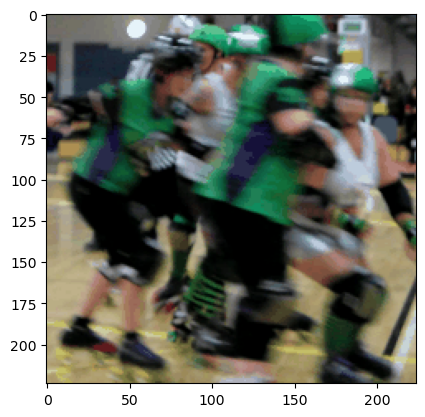

In [181]:
img = np.asarray(Image.open("./animation.gif").convert('RGB'))
imgplot = plt.imshow(img)
plt.show()

In [182]:
predict(sample_video)

Top 5 actions:
  roller skating        : 96.91%
  playing volleyball    :  1.60%
  skateboarding         :  0.21%
  playing ice hockey    :  0.19%
  playing basketball    :  0.16%


## Try video from our dataset

In [183]:
label = "Talking on phone"
video = "7394235874667711633_r5.mp4"
video_path = f"../../downloads/r2_test/{label}/{video}"
sample_video = load_video(video_path)[:100]
sample_video.shape

(100, 224, 224, 3)

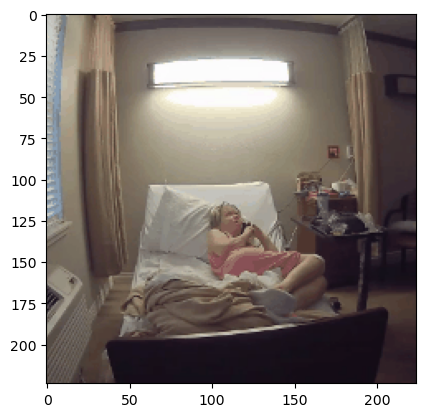

In [184]:
# Show a frame from the video for reference
gif = to_gif(sample_video)
img = np.asarray(Image.open("./animation.gif").convert('RGB'))
imgplot = plt.imshow(img)
plt.show()

In [188]:
pred = predict(sample_video)

Top 10 actions:
  reading newspaper     : 49.39%
  reading book          : 12.94%
  ripping paper         :  6.41%
  stretching leg        :  4.95%
  stretching arm        :  3.28%
  doing laundry         :  2.23%
  bending back          :  1.95%
  yoga                  :  1.77%
  folding napkins       :  1.11%
  applying cream        :  0.94%
